Simple and efficient tool for data mining and data analysis

In [1]:
import pandas as pd # dataframes
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import numpy as np
from pyspark.sql.types import *
import seaborn as sns # sits on top of Matplot
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # support vector classifiers
from sklearn import svm
from sklearn.neural_network import  MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
# we need this to visualize the data in jupyter notebooks only
%matplotlib inline 

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

23/02/12 11:10:34 WARN Utils: Your hostname, koshurlinux resolves to a loopback address: 127.0.1.1; using 192.168.1.11 instead (on interface enp8s0)
23/02/12 11:10:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/02/12 11:10:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Read and process test data

In [3]:
my_wine_data = spark.read.option("header",True).csv("./winequalityN.csv")
# my_wine_data.show()
# data processing


for column in my_wine_data.columns:
    new_col = str(column).lower().strip().replace(" ", "_")
    my_wine_data = my_wine_data.withColumnRenamed(column, new_col)


my_wine_data = my_wine_data.withColumn("type", col("type").cast(StringType()))
my_wine_data = my_wine_data.withColumn("fixed_acidity", col("fixed_acidity").cast(FloatType()))
my_wine_data = my_wine_data.withColumn("volatile_acidity", col("volatile_acidity").cast(FloatType()))
my_wine_data = my_wine_data.withColumn("citric_acid", col("citric_acid").cast(FloatType()))
my_wine_data = my_wine_data.withColumn("residual_sugar", col("residual_sugar").cast(FloatType()))
my_wine_data = my_wine_data.withColumn("chlorides", col("chlorides").cast(FloatType()))
my_wine_data = my_wine_data.withColumn("free_sulfur_dioxide", col("free_sulfur_dioxide").cast(FloatType()))
my_wine_data = my_wine_data.withColumn("density", col("density").cast(FloatType()))
my_wine_data = my_wine_data.withColumn("ph", col("ph").cast(FloatType()))
my_wine_data = my_wine_data.withColumn("sulphates", col("sulphates").cast(FloatType()))
my_wine_data = my_wine_data.withColumn("alcohol", col("alcohol").cast(FloatType()))
my_wine_data = my_wine_data.withColumn("quality", col("quality").cast(IntegerType()))
my_wine_data = my_wine_data.na.fill(value=0)


my_wine_data = my_wine_data.withColumn("quality", when(col("quality") >= 7, 1).otherwise(0))



display(my_wine_data.describe())

summary,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
count,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497
mean,null,7.205471759872178,0.3392727413206572,0.31857472737341985,5.442650450364028,0.05602431903715517,30.525319378174544,115.7445744189626,0.9946966336675106,3.2139372031505573,0.5308881008374575,10.491800813027597,0.19655225488687086
stddev,null,1.3262801689088408,0.16497832448626587,0.14539260301179405,4.7583509459002,0.035044425848902834,17.749399772002516,56.521854522630186,0.002998673927059...,0.20033749436879011,0.14935079953305228,1.1927117488301962,0.39742140889536737
min,red,0.0,0.0,0.0,0.0,0.0,1.0,10,0.98711,0.0,0.0,8.0,0
max,white,15.9,1.58,1.66,65.8,0.611,289.0,99,1.03898,4.01,2.0,14.9,1


In [4]:
# my_pandas_df_quality = my_wine_data.select("quality").toPandas()
# my_pandas_df_quality["quality"].value_counts()


my_wine_data.select("quality").groupBy("quality").count().show()
# type(my_pandas_df_quality["quality"])

+-------+-----+
|quality|count|
+-------+-----+
|      1| 1277|
|      0| 5220|
+-------+-----+



Plot a count plot

<AxesSubplot:ylabel='count'>

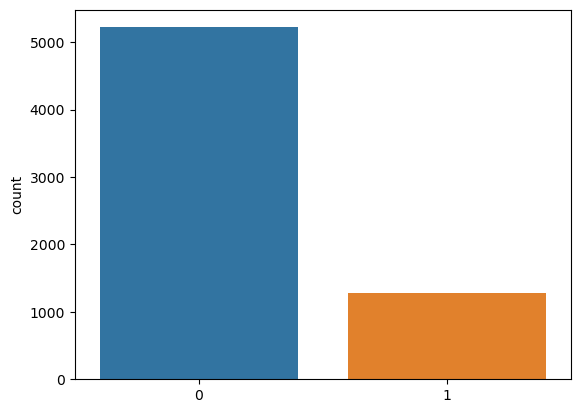

In [5]:
sns.countplot(x=[my_qual["quality"] for my_qual in my_wine_data.select("quality").collect()])

Separate our dataset

In [6]:
my_wine_features_x = my_wine_data.drop("quality", "type")
my_wine_quality_y = my_wine_data.select("quality")

Split the data into train and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(my_wine_features_x.collect(), my_wine_quality_y.collect(), test_size=0.2, random_state=42) # random state controlls shuffling

Feature Scaling

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

**Random Forest Classifier
**

In [9]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

# print(X_train[:20])
# print(pred_rfc)


print(classification_report(y_test, pred_rfc))

/tmp/ipykernel_14223/271586264.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1047
           1       0.77      0.45      0.57       253

    accuracy                           0.87      1300
   macro avg       0.82      0.71      0.74      1300
weighted avg       0.86      0.87      0.85      1300



Testing Random Forest Algorithm

In [10]:
print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))
print(accuracy_score(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1047
           1       0.77      0.45      0.57       253

    accuracy                           0.87      1300
   macro avg       0.82      0.71      0.74      1300
weighted avg       0.86      0.87      0.85      1300

[[1013   34]
 [ 140  113]]
0.8661538461538462


Random Forst Classifier doent have good performance

Support Vector Model

In [11]:
clf = svm.SVC()
clf.fit(X_train, y_train)
pred_clf = clf.predict(X_test)


/home/harsh/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Testing SVM

In [12]:
print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))
print(accuracy_score(y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1047
           1       0.66      0.28      0.39       253

    accuracy                           0.83      1300
   macro avg       0.75      0.62      0.65      1300
weighted avg       0.81      0.83      0.80      1300

[[1011   36]
 [ 183   70]]
0.8315384615384616


Neural Networks (Multi Layered Percepetron Classifier)

In [13]:
mlpc = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=500)
mlpc.fit(X_train, y_train)

pred_mlpc = mlpc.predict(X_test)

/home/harsh/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))
print(accuracy_score(y_test, pred_mlpc))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1047
           1       0.59      0.44      0.50       253

    accuracy                           0.83      1300
   macro avg       0.73      0.68      0.70      1300
weighted avg       0.82      0.83      0.82      1300

[[970  77]
 [142 111]]
0.8315384615384616
